# This is the minimum Working Example to compute a multiple scattering experiment in the Q-Phase 

In [3]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 10 19:53:32 2017

@author: Bene

This file creates a fwd-model for the TESCAN Q-PHASE under 
multiple-scattering. It is majorly derived from  "LEarning approach for optical tomography"
U. S. Kamilov, BIG, EPFL, 2014.
"""
# %load_ext autoreload
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import scipy as scipy

# load own functions
import src.model as mus
import src.tf_helper as tf_helper
import src.tf_generate_object as tf_go
import src.data as data

import src.optimization.tf_regularizers as reg
import os
from datetime import datetime

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')


# Define some optimization parameters 

In [4]:
'''Define some stuff related to infrastructure'''
mytimestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
savepath =  os.path.join('./Data/DROPLETS/RESULTS/', mytimestamp)
# Create directory
try: 
    os.mkdir(savepath)
except(FileExistsError): 
    print('Folder exists already')

tf.reset_default_graph()

is_flip = False
is_display = True
is_optimization = True 

'''Define Optimization Parameters'''
my_learningrate = 5e-4  # learning rate
lambda_tv = 1e-3 # lambda for Total variation
lambda_gr = 0 # lambda for Goods Roughness 
lambda_pos = 10
lambda_neg = 10

Niter = 10000
Ndisplay = 10

''' File which stores the experimental parameters from the Q-PHASE setup 
    1.) Read in the parameters of the dataset ''' 
matlab_par_file = './Data/EM-James/Parameter.mat'   # File with the experimental Parameters
matlab_pars = data.import_parameters_mat(filename = matlab_par_file, matname='myParameter')

''' 2.) Read in the parameters of the dataset ''' 
matlab_val_file = './Data/DROPLETS/allAmp_red.mat'   
matlab_val = data.import_realdata_h5(filename = matlab_val_file, matname='allAmp_red', is_complex=True)
if(is_flip):
    np_meas = np.flip(matlab_val,0)
else:
    np_meas = matlab_val
        
print('do we need to flip the data?! -> Observe FFT!!')

do we need to flip the data?! -> Observe FFT!!


# Initiate the MuScat (Multiple Scattering) Object

In [5]:
''' Create the Model'''
matlab_pars['shiftIcX'] = 0
matlab_pars['shiftIcY'] = 0
muscat = mus.MuScatModel(matlab_pars, is_optimization=False)
muscat.mysize = (muscat.Nz,muscat.Nx,muscat.Ny) # ordering is (Nillu, Nz, Nx, Ny)

#muscat.Nx,muscat.Ny = int(np.squeeze(matlab_pars['Nx'].value)), int(np.squeeze(matlab_pars['Ny'].value))

Assigned some value for dn which is not good!


## Compute the System's properties (e.g. Pupil function/Illumination Source, K-vectors, etc.)

## Generate a phantom object in 3D 

In [6]:
# INVERTING THE MISAGLINMENT OF THE SYSTEM! Its consered to be coma and/or shifted optical axis of the illumination in Y-direction!
muscat.dn = .05
diameter = .1
#muscat.NAc = .3

''' Create a 3D Refractive Index Distributaton as a artificial sample'''
obj = tf_go.generateObject(mysize=muscat.mysize, obj_dim=muscat.dx, obj_type ='sphere', diameter = diameter, dn = muscat.dn)

## Create computational graph

In [7]:
''' Compute the systems model'''
muscat.computesys(obj, is_zernike=True)

tf_fwd = muscat.computemodel()# Generate Test-Object

----------> Be aware: We are taking aberrations into account!
Shifting the illumination in X by: 0 Pixel
Shifting the illumination in Y by: 0 Pixel
Number of Illumination Angles / Plane waves: 120
Buildup Q-PHASE Model 


## Now evaluate the result - start inference

In [8]:
''' Evaluate the model '''
sess = tf.Session()
sess.run(tf.global_variables_initializer())
myres = sess.run(tf_fwd, feed_dict={muscat.TF_obj:obj})


## Visualize Results


IndexError: index 93 is out of bounds for axis 1 with size 32

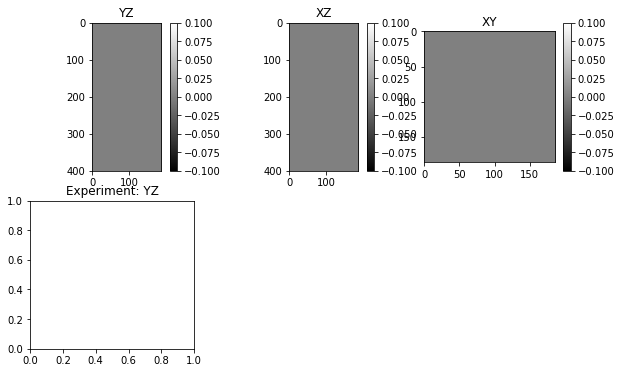

In [9]:
# add noise
myres_noise = myres + 0.00*np.random.randn(muscat.Nz,muscat.Nx,muscat.Ny)

fig = plt.figure()
#plt.title('Experiment: YZ'),plt.imshow(obj[:,muscat.mysize[1]//2,:]), plt.colorbar()
plt.subplot(231)
plt.title('YZ'),plt.imshow(np.angle(myres_noise)[:,muscat.mysize[1]//2,:]), plt.colorbar()
plt.subplot(232)
plt.title('XZ'),plt.imshow(np.angle(myres_noise)[:,:,muscat.mysize[2]//2]), plt.colorbar()
plt.subplot(233)
plt.title('XY'),plt.imshow(np.angle(myres_noise)[muscat.mysize[0]//2,:,:]), plt.colorbar()

plt.subplot(234)
plt.title('Experiment: YZ'),plt.imshow(np.angle(matlab_val)[:,muscat.mysize[1]//2,:]), plt.colorbar()
plt.subplot(235)
plt.title('Experiment: XZ'),plt.imshow(np.angle(matlab_val)[:,:,muscat.mysize[2]//2]), plt.colorbar()
plt.subplot(236)
plt.title('Experiment: XY'),plt.imshow(np.angle(matlab_val)[muscat.mysize[0]//2,:,:]), plt.colorbar()
fig.suptitle('ANGLE - This is the result for shiftX: '+str(shiftIcX)+', shiftY: '+str(shiftIcY)+', comaX: '+str(comaX)+', comaY: '+str(comaY))
plt.savefig('ANGLE_shiftX_'+str(shiftIcX)+'_shiftY_'+str(shiftIcY)+'_comaX_'+str(comaX)+'_comaY_'+str(comaY)+'_compare_fig.png', bbox_inches='tight')
plt.show()


fig = plt.figure()
plt.subplot(231)
plt.title('YZ'),plt.imshow(np.abs(myres_noise)[:,muscat.mysize[1]//2,:]), plt.colorbar()
plt.subplot(232)
plt.title('XZ'),plt.imshow(np.abs(myres_noise)[:,:,muscat.mysize[2]//2]), plt.colorbar()
plt.subplot(233)
plt.title('XY'),plt.imshow(np.abs(myres_noise)[muscat.mysize[0]//2,:,:]), plt.colorbar()

plt.subplot(234)
plt.title('Experiment: YZ'),plt.imshow(np.abs(matlab_val)[:,muscat.mysize[1]//2,:]), plt.colorbar()
plt.subplot(235)
plt.title('Experiment: XZ'),plt.imshow(np.abs(matlab_val)[:,:,muscat.mysize[2]//2]), plt.colorbar()
plt.subplot(236)
plt.title('Experiment: XY'),plt.imshow(np.abs(matlab_val)[muscat.mysize[0]//2,:,:]), plt.colorbar()
fig.suptitle('ABS - This is the result for shiftX: '+str(shiftIcX)+', shiftY: '+str(shiftIcY)+', comaX: '+str(comaX)+', comaY: '+str(comaY))
plt.savefig('ABS_shiftX_'+str(shiftIcX)+'_shiftY_'+str (shiftIcY)+'_comaX_'+str(comaX)+'_comaY_'+str(comaY)+'_compare_fig.png', bbox_inches='tight')
plt.show()

#data.save_timeseries(np.angle(matlab_val), 'droplet_meas_angle')
#data.save_timeseries(np.angle(myres), 'droplet_simu_angle') 
#%% save the results
np.save(savepath+'/rec.npy', myres)

tf_helper.saveHDF5(myres, savepath+'/Obj_Reconstruction.h5')
tf_helper.saveHDF5(np.abs(np_meas), savepath+'/Amplitude_abs.h5')
tf_helper.saveHDF5(np.angle(np_meas), savepath+'/Amplitude_angle.h5')